In [2]:
from pennylane import numpy as np
import pennylane as qml
import pickle
from scipy.linalg import eigh
from scipy.linalg import det

## Molecule definition

In [3]:
def angstrom_to_bohr(dist):
    return dist*1.88973

In [4]:
symbols = ["H","Be","H"]
dist = 1.3264
geometry = angstrom_to_bohr( np.array([[0, 0, -dist],[0.,0,0],[0,0,dist]]) )
mol = qml.qchem.Molecule(symbols, geometry)

In [5]:
active_electrons = 4
active_orbitals = 6

H, qubits = qml.qchem.molecular_hamiltonian(mol.symbols,
                                            mol.coordinates,
                                            active_electrons=active_electrons,
                                            active_orbitals=active_orbitals,
                                                      grouping_method = 'qwc',
                                                      args=[mol.coordinates])

In [6]:
generators = qml.symmetry_generators(H)
paulixops = qml.paulix_ops(generators, qubits)
paulix_sector = qml.qchem.optimal_sector(H, generators, active_electrons)

H_tapered_oldwires = qml.taper(H, generators, paulixops, paulix_sector)

/Users/Brian/workspace/Research/QHack2023/.conda/lib/python3.10/site-packages/pennylane/operation.py:1830: UserWarning: Tensor object acts on overlapping wires; in some PennyLane functions this will lead to undefined behaviour
  warnings.warn(
/Users/Brian/workspace/Research/QHack2023/.conda/lib/python3.10/site-packages/pennylane/operation.py:1993: UserWarning: Tensor object acts on overlapping wires; in some PennyLane functions this will lead to undefined behaviour
  warnings.warn(


In [ ]:
qubits_tap = qubits-len(paulixops)
wire_tapered = [ paulixops[i].wires[0] for i in range(len(paulixops))]
wire_tap = [ x for x in range(qubits) if not x in wire_tapered ]
wire_map = {wire:i for i,wire in enumerate(wire_tap)}


H_tapered = qml.map_wires(H_tapered_oldwires,wire_map)

In [ ]:
with open('gs.pkl','rb') as f:
    psi0 = pickle.load(f)

## Tools

In [ ]:
def rewrite_pauli_word_to_string(pw,qubits=qubits_tap):
    #qml.pauli_word_to_string()
    s = dict(pw.items())
    string=''
    for i in range(qubits):
        if i in s.keys():
            string+=s[i]
        else:
            string+='I'
    return string

    #return ''.join(['I' if i not in pw.wires else el 
    #                for i,el in enumerate(qml.pauli.pauli_word_to_string(pw))])

def cumulative_space(H,K):
    if K==0:
    # just return pauli word identity
        return [''.join(['I' for _ in range(qubits_tap)])]

    else:
        Id = ''.join(['I' for _ in range(qubits_tap)])
        PsH = qml.pauli.pauli_sentence(H)
        PsH_real = qml.pauli.PauliSentence( { pw : 1. for  pw,_ in PsH.items()})
        # maybe ? PsH_real.simplify()
        PsH_cumul = qml.pauli.PauliSentence( { pw : 1. for  pw,_ in PsH.items()})

        CSK = {rewrite_pauli_word_to_string(pw) for pw,_ in (PsH).items()}
        
        for _ in range(K-1):
            PsH_cumul = PsH_cumul * PsH_real
            CSK.update(*[rewrite_pauli_word_to_string(pw) for pw,_ in (PsH_cumul*PsH_real).items()])

                
        #basis = [{''.join(['I' for _ in range(qubits_tap)])},CS1]
        #for _ in range(K-1):
        #    CSK.update(basis[-2])
        #    basis.append(  increment_cummulative_space( basis[-1].difference(a)  ,CS1)   )
        #CSK.update(*basis[-2:])
    CSK.remove(Id)
    return [Id]+list(CSK)



In [ ]:
len(cumulative_space(H_tapered,1))
#qml.pauli.pauli_word_to_string(qml.Identity(0)@qml.PauliX(3))
#rewrite_pauli_word_to_string([pw for pw,_ in (PsH).items()][3]

#([ type(el) for el in H.ops][1])
#H.ops
#[pw for pw,_ in (PsH).items()][10]
#dict([pw for pw,_ in (PsH).items()][10].items())

268

In [ ]:
import dask 
import time
# Calculate the expectation value with the inital state psi0
# Could be improved with Dask or QWC elements

devs = [ qml.device("default.qubit", wires=qubits_tap) for _ in range(len(H_tapered.ops))]

def circuit(Pi_H_Pj):
    qml.QubitStateVector(psi0, range(qubits_tap))
    return qml.expval(Pi_H_Pj)


def compute_expect(H):
    qnode = qml.QNode(circuit, devs[0])(H)
    return qnode


def compute_energy_parallel(H, devs, param):
    assert len(H.ops) == len(devs)
    results = []

    for i in range(len(H.ops)):
        qnode = qml.QNode(circuit, devs[i])
        results.append(dask.delayed(qnode)(param, H.ops[i]))

    result = H.coeffs @ dask.compute(*results, scheduler="threads")
    return result


def compute_expect_parallel_optimized(H, devs=devs):
    assert len(H.ops) <= len(devs)
    results = []

    obs_groupings, coeffs_groupings = qml.pauli.group_observables(H.ops, H.coeffs, "qwc")
    for i, (obs, coeffs) in enumerate(zip(obs_groupings, coeffs_groupings)):
        # THE FOLLOWING CASE IS SURPRISINGLY HAPPENING SOMETIMES....
        #if(len(coeffs)!=len(obs)):
        #    print("lolilol ", len(coeffs)," ",coeffs, " ", len(obs), " ", obs )
        if(len(obs)> len(coeffs)):
            #print("AH")
            #print(type(coeffs))
            coeffs = qml.numpy.tensor( list(coeffs.unwrap()) + [0.+0.j for _ in range(len(obs)-len(coeffs))])
        
        H_part = qml.Hamiltonian(coeffs, obs)
        qnode = qml.QNode(circuit, devs[i])
        results.append(dask.delayed(qnode)(H_part))

    result = qml.math.sum(dask.compute(*results, scheduler="threads"))
    return result



In [ ]:
def expectation_obs(Pi,Pj, H=qml.Hamiltonian(coeffs=[1.], observables = [qml.Identity(0)])):
    """Computes the expectation value of a Hamiltonian sandwiched between two Pauli words.


    Args:
        Pi (_type_): _description_
        Pj (_type_): _description_
        psi0 (_type_): _description_
        H (_type_, optional): _description_. Defaults to None.
        parallel (bool, optional): _description_. Defaults to False.
        nvidia (bool, optional): _description_. Defaults to False.

    Returns:
        _type_: _description_
    """
    
    Pwi = qml.pauli.PauliWord(dict(zip(list(range(len(Pi))), Pi)))
    Pwj = qml.pauli.PauliWord(dict(zip(list(range(len(Pj))), Pj)))
    
    Psi = qml.pauli.PauliSentence({Pwi: 1.})
    Psj = qml.pauli.PauliSentence({Pwj: 1.})
    PsH = qml.pauli.pauli_sentence(H)

    Pi_H_Pj = Psi*PsH*Psj
    
    # BUG TO BE REPORTED : 
    # ps.Hamlitonian does not work in case ps contains complex coefficients: 
    # reproducer
    # pw1 = qml.pauli.PauliWord({0:"X"})
    # Psi = qml.pauli.PauliSentence({pw1: 1.,pw1: 1.2j})
    # Psi.hamiltonian()

    coeffs,ops = zip(*[ (coeff, pw.hamiltonian(wire_order=list(H_tapered.wires)).ops[0])  for pw, coeff in Pi_H_Pj.items()])
    

    Pi_H_Pj = qml.Hamiltonian( coeffs = coeffs,
                                observables = ops,
                                grouping_type="qwc",
                                simplify=True
                            )
    return Pi_H_Pj


# Construct the overlap matrix S
def S_mat(basis):
    N = len(basis)
    S_mat = np.ones((N,N), dtype=complex)
    for i in range(N):
        for j in range(i):
            H = expectation_obs(basis[i],basis[j])
            S_mat[i,j] = compute_expect(H)
            S_mat[j,i] = S_mat[i,j].conjugate()
    return S_mat


# Construct the matrix D
def D_mat(basis, H_tapered):
    N = len(basis)
    D_mat = np.zeros((N,N), dtype=complex)

    for i in range(N):
        for j in range(i):
            #D_mat[i,j] = expectation_value(basis[i],basis[j],psi0, H=H_tapered)
            #t0 = time.time()
            H_temp = expectation_obs(basis[i],basis[j], H=H_tapered)
            #t1 = time.time() - t0
            D_mat[i,j] = compute_expect(H_temp)
            D_mat[j,i] = D_mat[i,j].conjugate()    
            #t2 = time.time() - t0
        #if(i==0 and j==0):
            #print(f"Evaluation time operator: {t1:.2f} s")
            #print(f"Evaluation time expectation: {t2:.2f} s")
            
        H_temp = expectation_obs(basis[i],basis[i], H=H_tapered)      
        D_mat[i,i] = compute_expect(H_temp).real
    return D_mat



### Molecule

### Tapering

In [ ]:
H_mat = qml.matrix(H_tapered)
vals, vects = eigh(H_mat)
print(vals[0])
#print(vects[0])
lmbda=[]
vectlol = vects.transpose() 

print(vectlol.shape)

for el in vectlol[:1]:
    lmbda.append((np.matmul(el.conj().transpose(),np.matmul(H_mat, el)) / np.matmul(el.conj().transpose(),el)).real)

print(min(lmbda))
print()
print((np.matmul(psi0.conj().transpose(),np.matmul(H_mat, psi0))/ np.matmul(psi0.conj().transpose(),psi0)) )


-15.594837897443046
(128, 128)
-15.594837897443051

(-15.594467553190364-6.16297582203967e-33j)


In [ ]:
print(psi0[-8])
vects[0][-8]

(0.9867290797243192-1.6149869705664732e-18j)


0j

### Generalized eigenvalue problem

In [ ]:
basis = ['IIIIIII','XIIIIII','IXIIIII','IIXIIII','IIIXIII','IIIIXII','IIIIIXI','IIIIIIX']

#basis = cumulative_space(H_tapered,1)

#extract_basis = ['IIIIIII', 'YIIYZZX', 'ZZZIZZZ', 'IXZIIIZ', 'IYXIZZY', 'IZZXZXZ', 'YXIIYII', 'IYIXZZY']

extract_basis = ['IIIIIII', 'ZZZIZZZ', 'IYIXZZY']

print(extract_basis)
S = S_mat(extract_basis)
print(det(S))

['IIIIIII', 'ZZZIZZZ', 'IYIXZZY']
(0.057281954956401586+0j)


In [ ]:
D = D_mat(extract_basis, H_tapered)

In [ ]:
vals, vect = eigh(D,S, eigvals_only=False)
print(vals)

vect = vect.transpose()
#print(vect)

[-15.5955766  -14.58782631 -14.24263251]


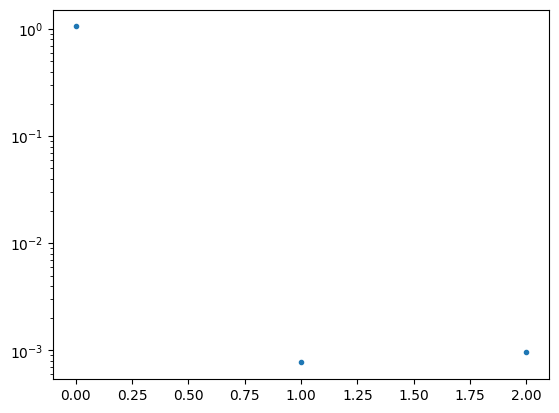

In [ ]:
from matplotlib import pyplot as plt

plt.plot(abs(vect[0])**2,'.')
plt.yscale('log')

In [ ]:
@qml.qnode(devs[0])
def krylov_vector(pauli_string,psi0):
    qml.BasisState(psi0, wires=H_tapered.wires)
    qml.apply(qml.pauli.string_to_pauli_word(pauli_string))
    qml.state()

krylov_list = np.zeros(len(extract_basis))
for i,pw in enumerate(extract_basis):
    krylov_list[i] = krylov_vector(pw,psi0) * vect[i]

np.sum(krylov_list)

NameError: name 'qml' is not defined

In [ ]:
H_tapered_sparse = qml.SparseHamiltonian(qml.utils.sparse_hamiltonian(H_tapered), wires=H_tapered.wires)

print("\nEigenvalues of H_tapered:\n", min(qml.eigvals(H_tapered_sparse, k=2**7)))


Eigenvalues of H_tapered:
 -15.594837897443053


In [ ]:
alpha = vect[0] #/np.sqrt(np.sum(np.abs(vects[0])**2))
print(alpha)

[-1.00018389-3.69544426e-16j  4.04626832+8.13128146e-12j]


ValueError: The number of FixedLocator locations (7), usually from a call to set_ticks, does not match the number of labels (268).

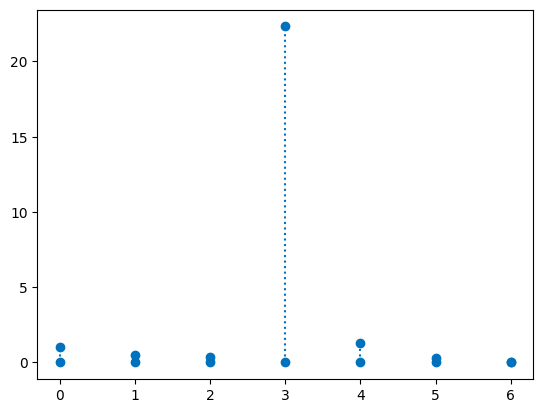

In [ ]:
for i in range(len(alpha)):
    plt.plot([i,i],[0,abs(alpha[i])**2],':o', color=[0, 0.4470, 0.7410])
plt.xticks(range(len(alpha)), labels=basis)
plt.xticks(rotation=45)
plt.yscale('log')
plt.show()